In [1]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import itertools 


## Create necessary classes and functions

Create class to handle "cities"

In [ ]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

    def __int__(self):
        return (self.x, self.y)

def generate_cities_list(num, seed=42):
    random.seed(seed)
    cityList = []
    for i in range(0, num):
        cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
    return cityList


In [2]:
class cities:
    def __init__(self, ncities):
        self.ncities = ncities
        self.cities = np.random.randint(0, 100, (ncities, 2))

    def copy(self):
        ct = cities(self.ncities)
        ct.cities = self.cities.copy()
        return ct

class route:
    def __init__(self, ct, rt=None):
        self.cities = ct.copy()
        if rt == None:
            self.route = np.random.permutation(ct.ncities)
        else:
            self.route = rt

    def copy(self):
        rt = route(self.cities)
        rt.route = self.route.copy()
        return rt

    def cost(self):
        dx = np.square(np.diff(self.cities.cities[self.route, 0]))
        dy = np.square(np.diff(self.cities.cities[self.route, 1]))
        return np.sum(np.sqrt(dx + dy))

    def show(self):
        plt.figure(figsize=(15, 12))
        plt.plot(self.cities.cities[self.route, 0], self.cities.cities[self.route, 1], marker = '.', markersize = 10)
        plt.title(f'Route cost = {self.cost()}')
        plt.show()


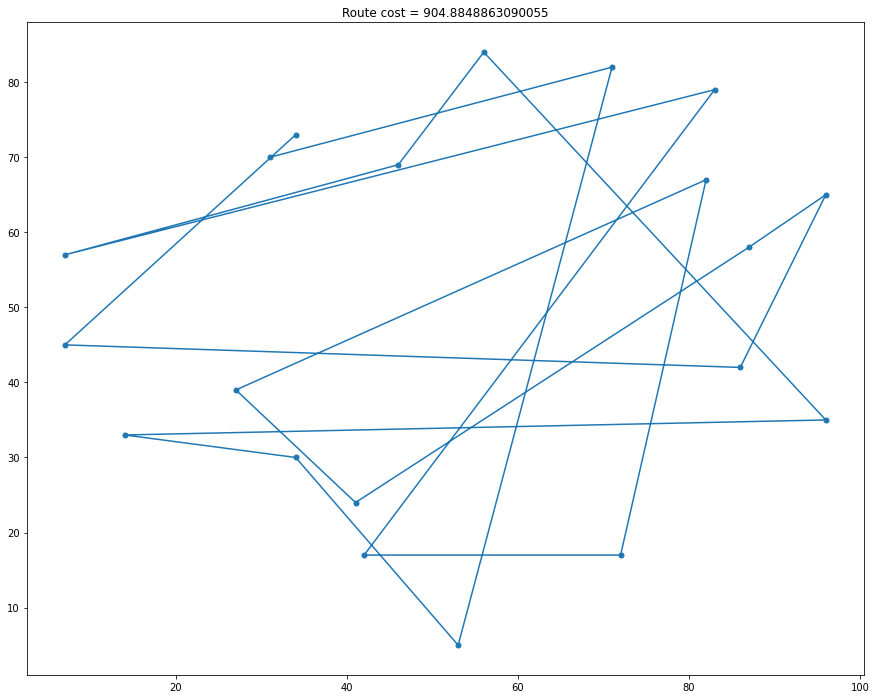

In [3]:
ct = cities(20)
rt = route(ct)
rt.show()



In [4]:
def hill_climbing(rstart, niter=10):
    current_route = rstart.copy()
    for iter in range(niter):
        route = current_route.copy()
        for comb in itertools.combinations(range(current_route.cities.ncities), 2):
            new_route = route.copy()
            new_route.route[comb[0]] = route.route[comb[1]]
            new_route.route[comb[1]] = route.route[comb[0]]
            if new_route.cost() < route.cost():
                route = new_route
        current_route = route
    return current_route


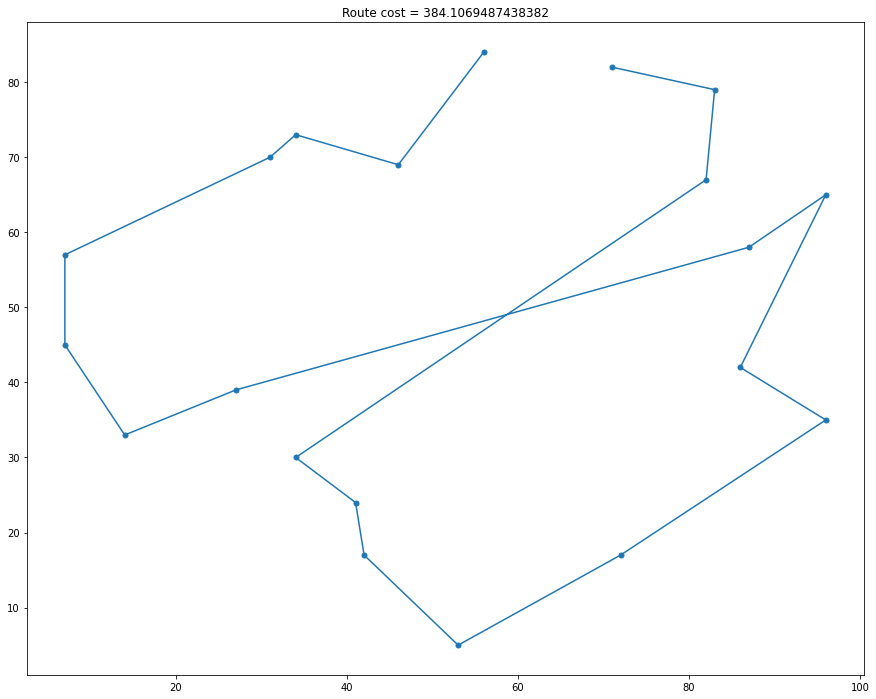

In [24]:
new_route = hill_climbing(route(ct), niter=50)
new_route.show()


In [6]:
def hill_climbing_restart(cities, nstarts, niter=10):
    best_rt = route(cities)
    for s in range(nstarts):
        new_rt = hill_climbing(route(cities), niter)
        if new_rt.cost() < best_rt.cost():
            best_rt = new_rt
    return best_rt


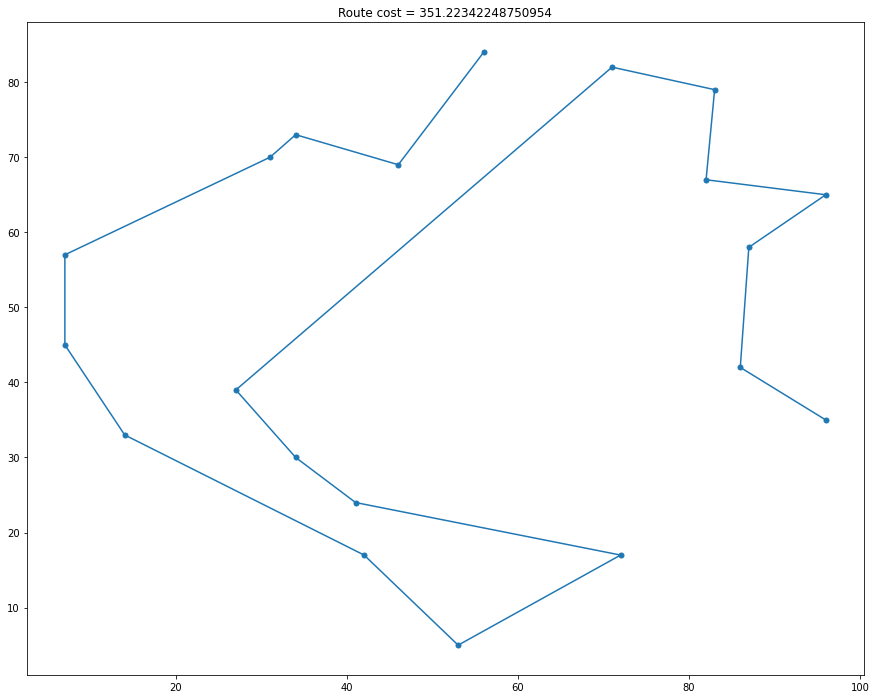

In [26]:
new_route = hill_climbing_restart(ct, nstarts=10, niter=50)
new_route.show()


In [11]:
def simulated_anealing(rstart, niter=10, temp=100.0):
    current_route = rstart.copy()
    for iter in range(niter):
        route = current_route.copy()
        for comb in itertools.combinations(range(current_route.cities.ncities), 2):
            new_route = route.copy()
            new_route.route[comb[0]] = route.route[comb[1]]
            new_route.route[comb[1]] = route.route[comb[0]]
            diff = route.cost() - new_route.cost()
            t = temp / (iter+1)
            metropolis = np.exp(-np.abs(diff)/t)
            if diff > 0 or np.random.rand() < metropolis:
                route = new_route
        current_route = route
    return current_route


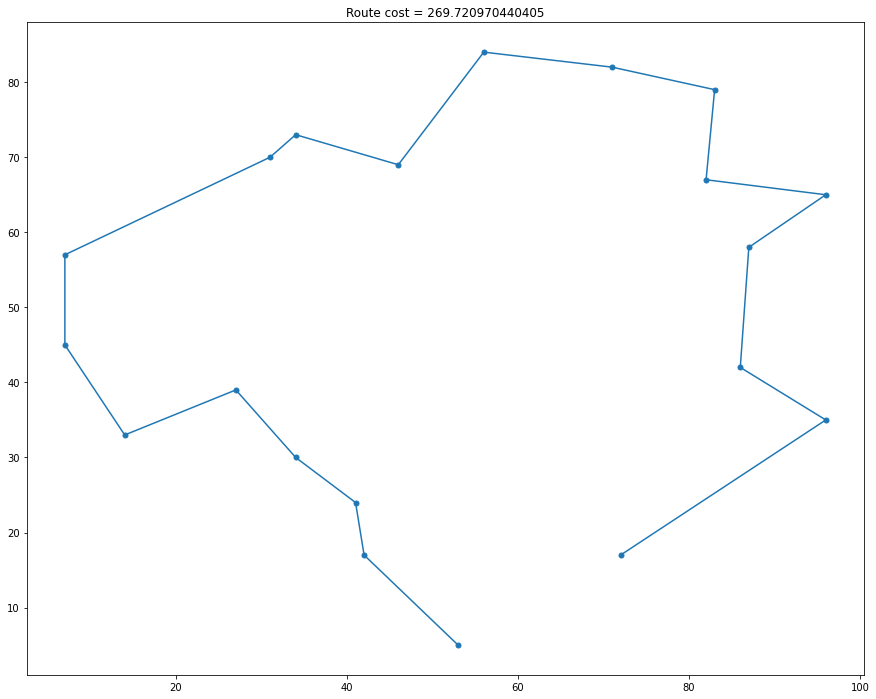

In [30]:
new_route = simulated_anealing(route(ct), niter=50, temp=100.0)
new_route.show()


Create a fitness function

In [ ]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [ ]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [ ]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [ ]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
  
pop = initialPopulation(1, cityList)
pop

[[(83,173),
  (33,34),
  (94,108),
  (63,3),
  (132,23),
  (175,83),
  (104,16),
  (105,178),
  (118,54),
  (95,1),
  (45,195),
  (93,130),
  (62,156),
  (88,173),
  (23,147),
  (134,162),
  (193,151),
  (42,182),
  (34,62),
  (84,94),
  (96,73),
  (127,83),
  (32,161),
  (66,26),
  (63,128)]]

## Create the genetic algorithm

Rank individuals

In [ ]:
rts = [route(2) for i in range(5)]


(array([[20, 82],
        [86, 74]]), array([[87, 99],
        [23,  2]]))

In [ ]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [ ]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [ ]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [ ]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [ ]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [ ]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [ ]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [ ]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [ ]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [ ]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Run the genetic algorithm

In [ ]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 2190.4798058923534
Final distance: 914.9834583953555


[(127,192),
 (100,168),
 (89,193),
 (80,188),
 (29,167),
 (17,145),
 (7,129),
 (59,121),
 (37,90),
 (51,91),
 (75,68),
 (73,47),
 (21,23),
 (24,11),
 (96,36),
 (126,10),
 (180,7),
 (150,54),
 (136,57),
 (133,66),
 (141,79),
 (128,121),
 (196,109),
 (179,132),
 (165,199)]

## Plot the progress

Note, this will win run a separate GA

In [ ]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

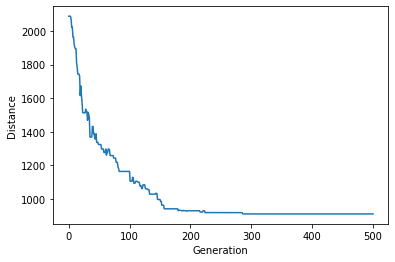

In [ ]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)